# RFM for analyzing customer value

RFM is a method used for analyzing customer value. "RFM" stands for the three dimensions:
1. Recency – How recently did the customer purchase? Customers who have purchased from you recently are more likely to buy from you again than customers who you haven’t seen for a while. 
2. Frequency – How often do they purchase? Customers who buy from you more often are more likely to buy again than customers who buy infrequently. 
3. Monetary Value – How much do they spend? Customers who spend more are more likely to buy again than customers who spend less.

Firstly, we have to decide the number of categories for each RFM attribute. The number and the interval of categories often depends on different business problems. For example, for Recency, it can be 3, 5 or 10 categories with a 2 month intervals. To calculate the value of these three dimension, all we need is the following information:
* Customer id
* Transaction id
* Date
* Amount

We then use these information to calculate RFM:
1. Recency: the difference between today and the last transaction date for each customer, then decide the interval of it.
2. Frequency: how frequently these customers purchase. We can use quantile to make customer into different categories or separate them by some pre-defined rules.
3. Monetary Value: total or average sales attributed to the customer.

To illustrate how to calculate RFM, we use the data we downloaded from [Online Retail Data Set](http://archive.ics.uci.edu/ml/datasets/Online+Retail) as the sample of this document.

## Read Data

It's is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.

In [145]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
color = sns.color_palette()

In [2]:
retail_df = pd.read_excel('_data/Online Retail.xlsx')

In [3]:
retail_df['InvoiceDate_date']=retail_df.InvoiceDate.map(lambda x: x.strftime('%Y-%m-%d'))
retail_df['InvoiceDate_YearMonth']=retail_df.InvoiceDate.map(lambda x: x.strftime('%Y-%m'))

In [125]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDate_date,InvoiceDate_YearMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12


In [215]:
retail_df = retail_df[(retail_df.CustomerID.notnull()) & (retail_df.Quantity>0)]
retail_df['CustomerID'] = retail_df['CustomerID'].apply(int).apply(str)

## EDA

##### Summary Statistics

In [217]:
retail_df.shape

(397924, 11)

In [216]:
retail_df.describe()

,Quantity,UnitPrice,Recency
count,397924.000000,397924.000000,397924.000000
mean,13.021823,3.116174,3.139052
std,180.420210,22.096788,1.584924
min,1.000000,0.000000,1.000000
25%,2.000000,1.250000,1.000000
50%,6.000000,1.950000,3.000000
75%,12.000000,3.750000,5.000000
max,80995.000000,8142.750000,5.000000


In [142]:
retail_df.InvoiceDate.describe()

count                  397924
unique                  17286
top       2011-11-14 15:27:00
freq                      542
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

##### What are the distribution or count value for each column?

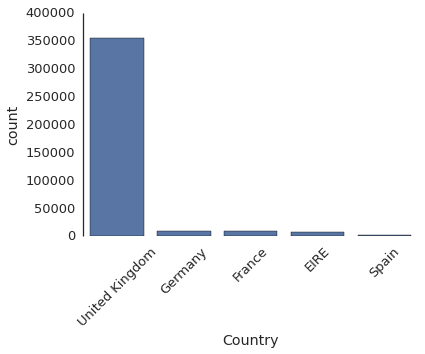

In [152]:
country_count=sns.countplot(x="Country", data=retail_df, color=color[0],order=retail_df.Country.value_counts().iloc[0:5,].index);
plt.setp(country_count.get_xticklabels(), rotation=45)
sns.despine(bottom=True)

##### How many orders are made in each month? 

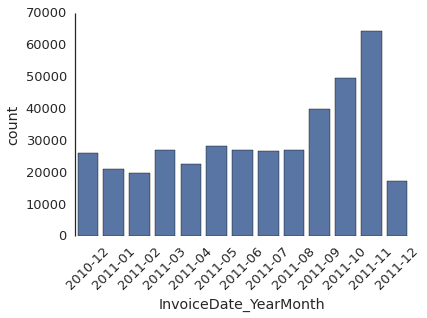

In [154]:
month_plot=sns.countplot(x="InvoiceDate_YearMonth", data=retail_df, color=color[0]);
plt.setp(month_plot.get_xticklabels(), rotation=45)
sns.despine(bottom=True)

##### What are the popular items?

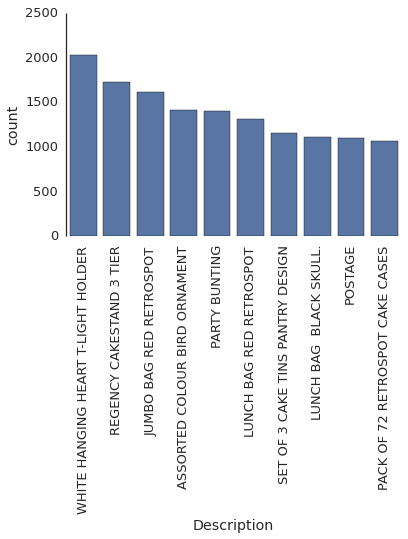

In [153]:
item_plot=sns.countplot(x="Description", data=retail_df, color=color[0],order=retail_df.Description.value_counts().iloc[0:10,].index);
plt.setp(item_plot.get_xticklabels(), rotation=90);
sns.despine(bottom=True)

### Calculate R

Let's define our Recency as 5 if the customer's last order is within 2 month; 4 if it's within 4 months...etc.

In [186]:
from pandas.tseries.offsets import *

In [194]:
def recency(row):
    last_day=pd.Timestamp(2011, 12, 9)
    if row['InvoiceDate'] > last_day + DateOffset(months=-2):
        val = 5
    elif row['InvoiceDate'] <= last_day + DateOffset(months=-2) and row['InvoiceDate'] > last_day + DateOffset(months=-4):
        val = 4
    elif row['InvoiceDate'] <= last_day + DateOffset(months=-4) and row['InvoiceDate'] > last_day + DateOffset(months=-6):
        val = 3
    elif row['InvoiceDate'] <= last_day + DateOffset(months=-6) and row['InvoiceDate'] > last_day + DateOffset(months=-8):
        val = 2
    else:
        val = 1
    return val

In [219]:
customer_df = pd.DataFrame(retail_df.groupby('CustomerID')['InvoiceDate'].max()).reset_index()
customer_df.head()

,CustomerID,InvoiceDate
0,12346,2011-01-18 10:01:00
1,12347,2011-12-07 15:52:00
2,12348,2011-09-25 13:13:00
3,12349,2011-11-21 09:51:00
4,12350,2011-02-02 16:01:00


In [220]:
customer_df['Recency'] = customer_df.apply(recency, axis=1)

In [342]:
recency_df = pd.DataFrame(retail_df.Recency.value_counts()).reset_index().sort_values(by='index', ascending=False)
recency_df

,index,Recency
0,5,325648
1,4,35257
2,3,15525
4,2,9082
3,1,12412


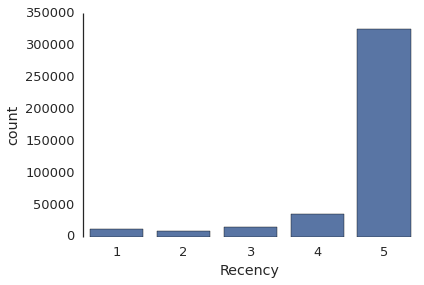

In [228]:
recency_plot=sns.countplot(x="Recency", data=retail_df, color=color[0]);
# plt.setp(item_plot.get_xticklabels(), rotation=90);
sns.despine(bottom=True)

In [350]:
final_customer_df = customer_df[['CustomerID','Recency']]
final_customer_df.head()

,CustomerID,Recency
0,12346,1
1,12347,5
2,12348,4
3,12349,5
4,12350,1


### Calculate F

Let's use the distribution of the frequency of all the customers and take its quantile as our frenquency score. For simplicity, I define the Frequency here as "The total number of the order for each user within last 365 days" instead of "How often do they purchase in certain period of time". Because of the distribution of our frequency, we make our F into 8 levels.

In [297]:
target_date = str(pd.Timestamp(retail_df.InvoiceDate_date.max())+ DateOffset(months=-12))

frequency_df = pd.DataFrame(retail_df[retail_df.InvoiceDate_date > target_date].groupby('CustomerID')['InvoiceNo'].nunique()
).reset_index()
frequency_df = frequency_df.rename(columns={'InvoiceNo':'Count'})
frequency_df.head()

,CustomerID,Count
0,12346,1
1,12347,6
2,12348,4
3,12349,1
4,12350,1


In [286]:
frequency_df[frequency_df.Count==frequency_df.Count.max()]

,CustomerID,Count
322,12748,193
1855,14911,193


In [291]:
len(retail_df[retail_df.CustomerID=='14911']['InvoiceNo'].unique())

201

In [296]:
retail_df[retail_df.CustomerID=='14911']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDate_date,InvoiceDate_YearMonth,Recency
1393,536540,22968,ROSE COTTAGE KEEPSAKE BOX,4,2010-12-01 14:05:00,9.95,14911,EIRE,2010-12-01,2010-12,5
1394,536540,85071A,BLUE CHARLIE+LOLA PERSONAL DOORSIGN,6,2010-12-01 14:05:00,2.95,14911,EIRE,2010-12-01,2010-12,5
1395,536540,85071C,"CHARLIE+LOLA""EXTREMELY BUSY"" SIGN",6,2010-12-01 14:05:00,2.55,14911,EIRE,2010-12-01,2010-12,5
1396,536540,22355,CHARLOTTE BAG SUKI DESIGN,50,2010-12-01 14:05:00,0.85,14911,EIRE,2010-12-01,2010-12,5
1397,536540,21579,LOLITA DESIGN COTTON TOTE BAG,6,2010-12-01 14:05:00,2.25,14911,EIRE,2010-12-01,2010-12,5
1398,536540,21576,LETS GO SHOPPING COTTON TOTE BAG,6,2010-12-01 14:05:00,2.25,14911,EIRE,2010-12-01,2010-12,5
1399,536540,22147,FELTCRAFT BUTTERFLY HEARTS,12,2010-12-01 14:05:00,1.45,14911,EIRE,2010-12-01,2010-12,5
1400,536540,22150,3 STRIPEY MICE FELTCRAFT,12,2010-12-01 14:05:00,1.95,14911,EIRE,2010-12-01,2010-12,5
1401,536540,22492,MINI PAINT SET VINTAGE,36,2010-12-01 14:05:00,0.65,14911,EIRE,2010-12-01,2010-12,5
1402,536540,22493,PAINT YOUR OWN CANVAS SET,24,2010-12-01 14:05:00,1.65,14911,EIRE,2010-12-01,2010-12,5


In [298]:
frequency_df.describe()

,Count
count,4265.000000
mean,4.164127
std,7.401750
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,193.000000


In [319]:
frequency_df['Freqency'] = pd.qcut(frequency_df['Count'], 20, labels=[1,2,3,4,5,6,7,8],duplicates='drop')
frequency_df.head()

,CustomerID,Count,Freqency
0,12346,1,1
1,12347,6,5
2,12348,4,3
3,12349,1,1
4,12350,1,1


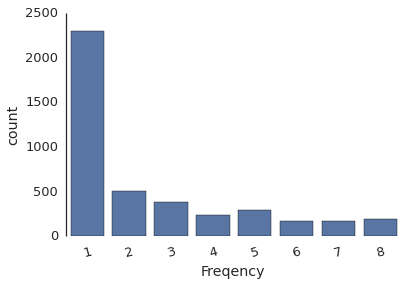

In [320]:
frequency_plot=sns.countplot(x="Freqency", data=frequency_df, color=color[0]);
plt.setp(frequency_plot.get_xticklabels(), rotation=15);
sns.despine(bottom=True)

In [348]:
frequency_df.head()

,CustomerID,Count,Freqency
0,12346,1,1
1,12347,6,5
2,12348,4,3
3,12349,1,1
4,12350,1,1


In [351]:
final_customer_df = pd.merge(final_customer_df,frequency_df[['CustomerID','Freqency']],on='CustomerID', how='left')
final_customer_df.head()

,CustomerID,Recency,Freqency
0,12346,1,1
1,12347,5,5
2,12348,4,3
3,12349,5,1
4,12350,1,1


### Calculate M

For the monetary value, let's use the distribution of the total purchase within 1 year of all the customers and take its quantile as our monetary score score.

In [ ]:
retail_df['total_price']=retail_df['Quantity'] * retail_df['UnitPrice']

In [334]:
target_date = str(pd.Timestamp(retail_df.InvoiceDate_date.max())+ DateOffset(months=-12))

monetary_df = pd.DataFrame(retail_df[retail_df.InvoiceDate_date > target_date].groupby('CustomerID')['total_price'].agg('sum')
).reset_index()
monetary_df.head()

,CustomerID,total_price
0,12346,77183.60
1,12347,3598.21
2,12348,1797.24
3,12349,1757.55
4,12350,334.40


In [339]:
monetary_df['Monetary'] = pd.qcut(monetary_df['total_price'], 5, labels=[1,2,3,4,5])
monetary_df.head()

,CustomerID,total_price,Monetary
0,12346,77183.60,5
1,12347,3598.21,5
2,12348,1797.24,4
3,12349,1757.55,4
4,12350,334.40,2


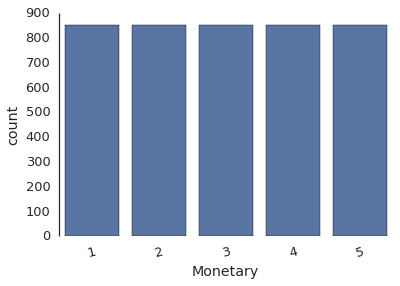

In [340]:
monetary_plot=sns.countplot(x="Monetary", data=monetary_df, color=color[0]);
plt.setp(monetary_plot.get_xticklabels(), rotation=15);
sns.despine(bottom=True)

In [352]:
final_customer_df = pd.merge(final_customer_df,monetary_df[['CustomerID','Monetary']],on='CustomerID', how='left')

### Get the Final RFM Score

In [364]:
final_customer_df.head()

,CustomerID,Recency,Freqency,Monetary
0,12346,1,1,5
1,12347,5,5,5
2,12348,4,3,4
3,12349,5,1,4
4,12350,1,1,2


In [381]:
final_customer_df['Recency'] = final_customer_df['Recency'].apply(int).apply(str)
final_customer_df['Freqency'] = final_customer_df['Freqency'].apply(int).apply(str)
final_customer_df['Monetary'] = final_customer_df['Monetary'].apply(int).apply(str)

In [382]:
final_customer_df['RFM'] = final_customer_df[['Recency','Freqency','Monetary']].apply(lambda x : '{}{}{}'.format(x[0],x[1],x[2]), axis=1)

In [383]:
final_customer_df.head()

,CustomerID,Recency,Freqency,Monetary,RFM
0,12346,1,1,5,115
1,12347,5,5,5,555
2,12348,4,3,4,434
3,12349,5,1,4,514
4,12350,1,1,2,112


---

### End Note
The higher RFM of the customer, the higher lifetime value for the customer is. We can use the calculated table, final_customer_df, to segment our customers by different RFM.

Reference
* http://www.eightleaves.com/2011/01/using-rfm-to-identify-your-best-customers
* https://en.wikipedia.org/wiki/RFM_(customer_value)
* https://medium.com/@tomar.ankur287/customer-segmentation-using-rfm-analysis-in-python-bb6f1bd2fce5